In [1]:
import re
import uuid
import pickle
from unicodedata import normalize
from string import punctuation
import warnings
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import cpu_count
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import spacy
import nltk
from nltk.cluster import KMeansClusterer
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import homogeneity_score, completeness_score, silhouette_score, davies_bouldin_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding
from sklearn.decomposition import NMF
from sklearn.cluster import DBSCAN, OPTICS, KMeans
from pyclustering.cluster.xmeans import xmeans, kmeans
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.elbow import elbow
from pyclustering.cluster.silhouette import silhouette_ksearch_type, silhouette_ksearch
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from IPython.display import HTML

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

warnings.filterwarnings('ignore')
np.random.seed(123456)

%matplotlib inline

In [2]:
def remover_acentos(txt):
    return normalize('NFKD', txt).encode('ASCII', 'ignore').decode('ASCII')

def is_number(s):
    try:
        complex(s) # for int, long, float and complex
    except ValueError:
        return False
    return True

def tokenizer(phrase):
    phrase = phrase.lower()
    for o, r in RM:
        phrase = re.sub(o, r, phrase, flags=re.MULTILINE)
    phrase = re.sub(r'["\'@#%\(\)$0-9]', " ", phrase)
    phrase = NLP(re.sub(r'[-+=:]', "", phrase), disable=["parser"])
    clean_frase = []
    for palavra in phrase:
        if palavra.pos_ != "PUNCT":
            word = palavra.text.strip()
            if not is_number(word) and word not in STOPWORDS and len(word) > 1:
                try:
                    word = VERBOS[word]
                except:
                    word = palavra.lemma_
                clean_frase += [remover_acentos(word)]
                # clean_frase += [STEMMER.stem(remover_acentos(palavra.lemma_))]
    return clean_frase

def _get_stopwords():
    stpwords = sorted(list(set(stopwords.words('portuguese') + list(NLP.Defaults.stop_words) + list(punctuation))))
    rms = ["um", "uma", "não", "mais", "muito", "você"]
    for rm in rms:
        del stpwords[stpwords.index(rm)]
    return stpwords

# NLP = spacy.load("pt")
# STEMMER = nltk.stem.RSLPStemmer()
NLP = spacy.load('pt_core_news_sm')
STEMMER = nltk.stem.SnowballStemmer('portuguese')
STOPWORDS = _get_stopwords()
RM = [
    ('\n', '. '), ('"', ''), ('@', ''),
    ('#', ''), ('RT', ''), (r'(http[s]*?:\/\/)+.*[\r\n]*', '')
]

VERBOS = {}
with open("datasets/verbs.pkc", "rb") as infile:
    verbos = pickle.load(infile)
    for verb in verbos:
        for v in list(verb.values())[0]:
            VERBOS[v] = list(verb.keys())[0]
    
colors = np.asarray([
    (230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48), (145, 30, 180), (70, 240, 240),
    (240, 50, 230), (210, 245, 60), (250, 190, 190), (0, 128, 128), (230, 190, 255), (170, 110, 40), (255, 250, 200),
    (128, 0, 0), (170, 255, 195), (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128), (0, 0, 0),
    (141, 204, 226), (212, 50, 147), (251, 226, 93), (16, 185, 176), (189, 182, 163), (244, 172, 18), (100, 28, 112),
    (165, 124, 92), (183, 160, 211), (66, 47, 105), (240, 67, 7), (244, 188, 198)
]).astype(np.float32) / 255.0

### Carregamento dos datasets

Os datasets de exemplos são frases já pré-categorizadas usadas em chatbots.

Contém 33 categorias e ao todo 696 documentos ou frases.

In [3]:
dataset = 1

if dataset == 1:
    df_data = pd.read_csv("datasets/intents.csv", sep=';', names=["cluster", "perguntas"])
    df_data = df_data[df_data.columns[::-1]]
    df_data.dropna(inplace=True)
    df_data['cluster'] = df_data['cluster'].str.upper()
elif dataset == 2:
    df_data = pd.read_csv("datasets/ground_truth.csv", sep=';', names=["perguntas", "cluster"])
    df_data.dropna(inplace=True)
    df_data['cluster'] = df_data['cluster'].str.upper()
else:
    df_data1 = pd.read_csv("datasets/intents.csv", sep=';', names=["cluster", "perguntas"])
    df_data2 = pd.read_csv("datasets/ground_truth.csv", sep=';', names=["perguntas", "cluster"])

    df_data1 = df_data1[df_data1.columns[::-1]]
    df_data = pd.concat([df_data1, df_data2], sort=False)
    df_data.dropna(inplace=True)
    df_data['cluster'] = df_data['cluster'].str.upper()

T = df_data.to_numpy()
index = np.random.choice(T.shape[0], 10, replace=False)
display(df_data.iloc[index].sort_values(by=["cluster"]))

c = np.argmax(pd.get_dummies(df_data["cluster"]).to_numpy(), axis=1)

N = df_data["cluster"].to_numpy().shape[0]
clusters = len(set(c))
colors = colors[range(0, clusters)]

,perguntas,cluster
198,como faco para trocar o meu usuario,ACCOUNT
204,eu consigo trocar meu username para outro?,ACCOUNT
237,estou falando com um bot não?,BOT_FOUND
226,quero solicitar a renovação de um certificado digital,CERTIFICATE
148,estou sem acesso ao meu endereco eletronico,EMAIL
167,como saber mais sobre o email da empresa,EMAIL
113,quais outras opções tem para me mostrar?,NO_OPTION
119,nenhuma dessas opções me ajuda,NO_OPTION
23,Não consigo trocar a minha senha,PASSWORD
0,posso consultar informações relativas a outros serviços e projetos?,SERVICES


In [4]:
uniq, cnt = np.unique(np.asarray(df_data["cluster"]), return_counts=True)
df_org = pd.DataFrame(np.array(list(zip(uniq, cnt))), columns=["Categoria", "Qtde"])

print("Qtde. de documentos por categoria:")
display(df_org.sort_values(by=["Categoria"]))

Qtde. de documentos por categoria:


,Categoria,Qtde
0,ACCOUNT,29
1,BOT_FOUND,20
2,BOT_NAME,16
3,CERTIFICATE,18
4,EMAIL,40
5,NO_OPTION,18
6,PASSWORD,27
7,REMOTE_ACCESS,20
8,SERVICES,20
9,THANK_YOU,23


In [5]:
X_train, X_test, y_train, y_test = train_test_split(df_data["perguntas"], c, test_size=0.2)

qtde_docs = len(df_data["perguntas"])
qtde_categ = len(df_data["cluster"])
print(f"Total docs     : {qtde_docs}")
print(f"Total cluster  : {qtde_categ}")
print(f"X_train size   : {X_train.shape}")
print(f"X_test  size   : {X_test.shape}")

Total docs     : 272
Total cluster  : 272
X_train size   : (217,)
X_test  size   : (55,)


### Dataset tokenization

In [6]:
P = X_train.shape[0]
print("Tokenization...")
documents_tfidf = [" ".join(tokenizer(doc)) for doc in X_train]
print("Qtd documentos treino: ", len(documents_tfidf))
print("Qtd Intents treino   : ", len(np.unique(df_data["cluster"].to_numpy())))
print("Finished...")

Tokenization...
Qtd documentos treino:  217
Qtd Intents treino   :  12
Finished...


In [7]:
documents_tfidf[:10]

['existir algum maneirar alterar nome usuario',
 'nao precisar mais',
 'configurar outlook',
 'senha acessar',
 'certificar digitar',
 'mais email empresar',
 'necessario instalar algum software adicional conectar redar fiar',
 'alterar senha usuario',
 'opcao ajudar',
 'email nao entrar acessar']

### **TF-IDF**

In [8]:
kmin = 5
kmax = 40

In [20]:
tfidf = TfidfVectorizer(max_features=1000)
X_trans = tfidf.fit_transform(documents_tfidf)

Validação do modelo gerado pelo TF-IDF... teste tanto nos dados apresentados para treinamento quanto nos dados de testes e as acurácias alcançadas.

In [21]:
T = 100 if X_train.shape[0] > 100 else X_train.shape[0]
dc = np.c_[X_train, y_train]
docs = utils.shuffle([doc for doc in dc], n_samples=T)
docs = [" ".join(tokenizer(doc)) for doc, y in docs]
sim = np.round(1 - cosine_similarity(tfidf.transform(docs)), 3)
acc = []
for i, xt in enumerate(dc[:T]):
    acc.append(int(xt[1]) == int(dc[np.where(sim[i] <= 0.3)][0][1]))
print("- Acurácia treino:", np.round(np.mean(acc) * 100, 2))
print("-" * 20)


def validate(X_trans, y_train, tfidf, doc):
    doct = tfidf.transform([doc[0]])
    sim = np.round(1 - cosine_similarity(doct, X_trans), 3).ravel()
    dcs = np.where(sim <= 0.3)
    it = 0.35
    while len(dcs[0]) == 0:
        dcs = np.where(sim <= it)
        it += 0.05
    return int(doc[1]) == int(y_train[dcs[0][0]])

accc = []
T = 100 if X_test.shape[0] > 100 else X_test.shape[0]
dc = np.c_[X_test, y_test]
with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    for p in range(5):
        docs1 = utils.shuffle([doc for doc in dc], n_samples=T)
        docs = np.array([[" ".join(tokenizer(doc)), y] for doc, y in docs1])
        acc = list(exc.map(partial(validate, X_trans, y_train, tfidf), docs))
        print(f" - Acurácia teste {p+1}  :", np.round(np.mean(acc) * 100, 2))
        accc += acc
print("- Acurácia média teste:", np.round(np.mean(accc) * 100, 2))

- Acurácia treino: 89.0
--------------------
 - Acurácia teste 1  : 78.18
 - Acurácia teste 2  : 78.18
 - Acurácia teste 3  : 78.18
 - Acurácia teste 4  : 78.18
 - Acurácia teste 5  : 78.18
- Acurácia média teste: 78.18


### Clusterização

Utilizou-se o KMeans definindo a quantidade de clusters para o número ideal de categorias existentes no caso 33. A métrica de distância utilizada, não foi a euclidiana, mas sim a de cosseno (métrica comumente usada na classificação de texto em seu espaço vetorial).

In [22]:
X = np.array(tfidf.transform(documents_tfidf).todense())
XT = np.array(tfidf.transform([" ".join(tokenizer(doc)) for doc in X_test]).todense())

In [23]:
# from pyclustering.utils.metric import distance_metric, type_metric
# from pyclustering.utils import calculate_distance_matrix
# metric = distance_metric(type_metric.USER_DEFINED, func=cosine_distance)

# # initial_centers = kmeans_plusplus_initializer(X, kmin).initialize()
# # kmeans_inst_ = kmeans(X, initial_centers=initial_centers, metric=metric, itermax=1000)
# # kmeans_inst_ = xmeans(X, initial_centers=initial_centers, kmax=kmax, metric=metric, repeat=1000)

# initial_medoids = np.random.randint(1, X.shape[0]-1, 32)
# kmeans_inst_ = kmedoids(
#     calculate_distance_matrix(X, metric=metric),
#     initial_medoids,
#     data_type='distance_matrix',
#     itermax=1000
# )
# kmeans_inst_.process()

# assigned_clusters = np.zeros(X.shape[0])
# clustered = kmeans_inst_.get_clusters()
# for i, elms in enumerate(clustered):
#     assigned_clusters[elms] = i

# centroids = X[kmeans_inst_.get_medoids()]
# # centroids = kmeans_inst_.get_centers()
# clusters = len(centroids)

In [24]:
kclusterer = KMeansClusterer(
    clusters,
    distance=cosine_distance,
    initial_means=utils.shuffle(X, n_samples=clusters).tolist(),
    avoid_empty_clusters=True
)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
assigned_clusters = np.array(assigned_clusters).ravel()
centroids = kclusterer.means()

In [25]:
docs = np.asarray(X_train)

info = []
frases = []
for i in range(clusters):
    idx = np.where(assigned_clusters == i)[0]
    for doc in docs[idx]:
        frases.append([doc, i])
    info.append([i, len(docs[idx])])

df = pd.DataFrame(frases, columns=["perguntas", "cluster"])
df_inf = pd.DataFrame(np.c_[[f"C{i}" for i in range(clusters)], np.asarray(info)[:, 1]])

print("Frases por cluster:")
data = []
for i in range(clusters):
    T = df.to_numpy()
    data += utils.shuffle(T[T[:, 1] == i], n_samples=2).tolist()
df = pd.DataFrame(data, columns=["title", "cluster"])
display(HTML(df.sort_values(by=["cluster"]).to_html(index=False)))

print("-" * 20)
print("Documentos por cluster:")
HTML(df_inf.to_html(index=False, header=False))

Frases por cluster:


title,cluster
as pessoas te chamam como?,0
essas opções não me ajudam em nada,0
qual o nome que lhe foi dado?,1
é possível trocar o meu username?,1
quero mais informacoes sobre senhas e como proceder,2
como faco para trocar o meu usuario,2
Você não conseguiu me ajudar,3
quais outras informações sobre serviços prestados você oferece?,3
minha conta de email foi desativada,4
Como posso criar uma conta para Colaborador Externo?,4


--------------------
Documentos por cluster:


C0,25
C1,22
C2,19
C3,37
C4,9
C5,27
C6,6
C7,11
C8,15
C9,10
C10,22


### Visualização

Apresentação dos protótipos gerados pelo KMeans, reduzindo a dimensão usando o algoritmo MDS (Multidimensional Scaling).

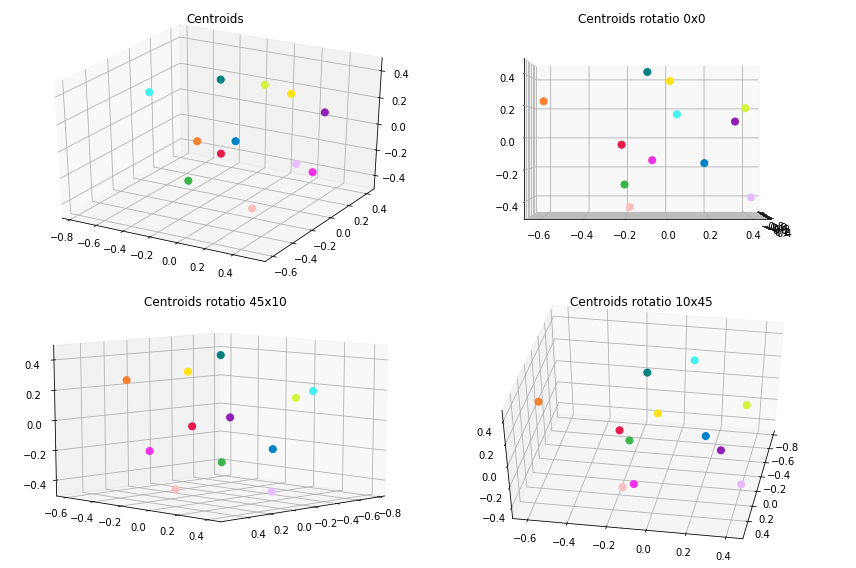

In [26]:
mds = MDS(
    n_components=3,
    n_init=5,
    max_iter=500,
    random_state=0,
    n_jobs=-1
)
X_cnt = mds.fit_transform(centroids)

plt.figure(figsize=(12, 8))
ax = plt.subplot(2, 2, 1, projection='3d')
plt.title("Centroids")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax = plt.subplot(2, 2, 2, projection='3d')
plt.title("Centroids rotatio 0x0")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax.view_init(0, 0)
ax = plt.subplot(2, 2, 3, projection='3d')
plt.title("Centroids rotatio 45x10")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax.view_init(10, 45)
ax = plt.subplot(2, 2, 4, projection='3d')
plt.title("Centroids rotatio 10x45")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax.view_init(45, 10)
plt.tight_layout()
plt.show()

### Clusterização dos dados de Teste

Por fim, realizada a clusterização dos dados de teste e a apresentação das 8 primeiras frases do conjunto de teste juntamente com outras duas frases do cluster ao qual foi identificado como o melhor.

In [27]:
Xtest = X_test.to_numpy()
for i, xt in enumerate(XT[:8]):
    clt = kclusterer.classify(xt)
    print("*", Xtest[i])
    for frase in utils.shuffle(df[df["cluster"] == clt].to_numpy())[:2]:
        print("  - ", frase[0])
    print("-" * 20)

* Meu email está com problema
  -  consigo recuperar emails perdidos?
  -  inseri o email e senha e não deu certo
--------------------
* existem mais serviços com os quais eu posso consultar?
  -  Você não conseguiu me ajudar
  -  quais outras informações sobre serviços prestados você oferece?
--------------------
* como eu faco para criar um novo usuario?
  -  minha conta de email foi desativada
  -  Como posso criar uma conta para Colaborador Externo?
--------------------
* como me conectar ao wifi (rede sem fio) da empresa
  -  e necessario instalar algum software adicional para conectar na rede sem fio?
  -  quero me conectar a rede sem fio
--------------------
* eu consigo alterar meu nome de usuário para outro?
  -  qual o nome que lhe foi dado?
  -  é possível trocar o meu username?
--------------------
* qual usuario e senha usar para acessar os sistemas?
  -  quero mais informacoes sobre senhas e como proceder
  -  como faco para trocar o meu usuario
--------------------
* Não

### Métricas

Abaixo são apresentadas métricas para demonstrar o quanto a clusterização parece funcionar.

In [28]:
hom = homogeneity_score(y_test, [kclusterer.classify(xt) for xt in XT])
compl = completeness_score(y_test, [kclusterer.classify(xt) for xt in XT])
silh = silhouette_score(XT, labels=[kclusterer.classify(xt) for xt in XT], metric="cosine", random_state=0)

print("Homogeneidade: ", np.round(hom, 3))
print("Completude   : ", np.round(compl, 3))
print("Silhouette   : ", np.round(silh, 3))

Homogeneidade:  0.808
Completude   :  0.84
Silhouette   :  0.118


In [29]:
def multi_kmeans(Xtf, k):
    error = True
    while error:
        try:
            initial_means = utils.shuffle(Xtf, n_samples=k).tolist()
            kclusterer_ = KMeansClusterer(
                k,
                initial_means=initial_means,
                distance=cosine_distance,
                avoid_empty_clusters=True
            )
            assigned_clusters = kclusterer_.cluster(Xtf, assign_clusters=True)
            error = False
        except:
            pass
    hom = homogeneity_score(y_train, assigned_clusters)
    compl = completeness_score(y_train, assigned_clusters)
    silh = silhouette_score(Xtf, labels=assigned_clusters, metric="cosine", random_state=0)
    return {"K": k, "HOM": hom, "COMPL": compl, "SILH": silh}

clusterizacao = []
with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    results = list(exc.map(partial(multi_kmeans, X), range(kmin, kmax), chunksize=10))
    for r in results:   
        clusterizacao.append({
            "Qtd. Cluster": r["K"],
            "Homogeneity": np.round(r["HOM"], 3),
            "Completeness": np.round(r["COMPL"], 3),
            "Silhouette": np.round(r["SILH"], 3)
        })

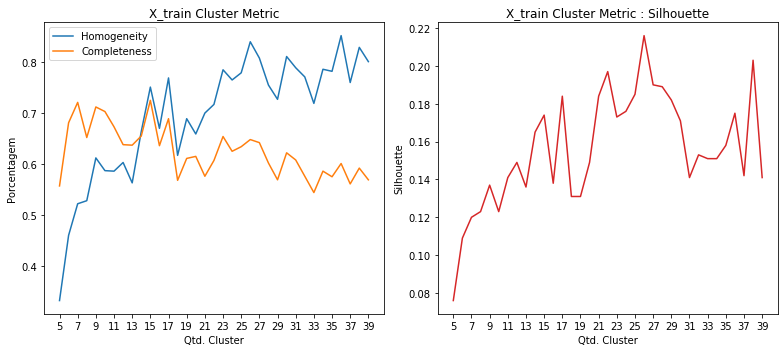

In [30]:
df_cluster = pd.DataFrame(clusterizacao, columns=["Qtd. Cluster", "Homogeneity", "Completeness", "Silhouette"])

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.plot(df_cluster["Qtd. Cluster"], df_cluster["Homogeneity"], label="Homogeneity")
plt.plot(df_cluster["Qtd. Cluster"], df_cluster["Completeness"], label="Completeness")
plt.xticks(range(kmin, kmax, 2))
plt.title("X_train Cluster Metric")
plt.xlabel("Qtd. Cluster")
plt.ylabel("Porcentagem")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("")
plt.plot(df_cluster["Qtd. Cluster"], df_cluster["Silhouette"], c="C3")
plt.xticks(range(kmin, kmax, 2))
plt.title("X_train Cluster Metric : Silhouette")
plt.xlabel("Qtd. Cluster")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()